In [1]:
###############################################################################
#          DÉBUT : IMPORTER LES LIBRAIRIES NÉCESSAIRES
###############################################################################
 
import numpy as np
import matplotlib.pyplot as plt
import ot
 
###############################################################################
#        FIN : IMPORTER LES LIBRAIRIES NÉCESSAIRES
###############################################################################

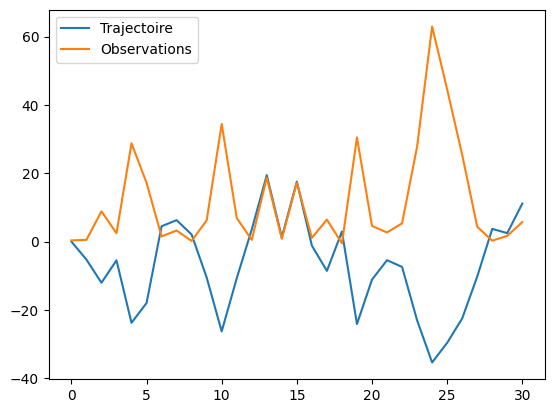

In [2]:
###############################################################################
#        DÉBUT : DÉFINIR ET SIMULER LE MODÈLE D'ÉTATS D'ESPACE
###############################################################################
# Paramètres de la simulation
simTime = 30
x0 = 0
Q = 10
R = 1

# Stockage de la trajectoire d'états
stateTrajectory = np.zeros(simTime+1)

# Mettre l'état initial
stateTrajectory[0] = x0

# Simuler le modèle
for i in range(simTime):
    stateTrajectory[i+1] = 0.5 * stateTrajectory[i] + 25 * (stateTrajectory[i] / (1 + stateTrajectory[i]**2)) + 8 * np.cos(1.2 * i) + np.random.normal(0, Q)

observations = ((stateTrajectory**2) / 20) + np.random.normal(0, R, len(stateTrajectory))

# Vérification visuelle
plt.plot(stateTrajectory, label='Trajectoire')
plt.plot(observations, label='Observations')
plt.legend()
plt.show()

def transition(particles, n, Q):
    return 0.5 * particles + 25 * particles / (1 + particles**2) + 8 * np.cos(1.2 * n) + np.random.normal(0, Q, size=particles.shape)

def likelihood_fn(particles, observation, R):
    predicted_observation = particles**2 / 20
    return np.exp(-0.5 * ((predicted_observation - observation) ** 2) / R)

def reechantillonnage(particles, weights):
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices]

def optimal_transport_resampling(particles, weights):
    N = len(weights)
    target_weights = np.ones(N) / N  # Uniform distribution
    C = ot.dist(particles.reshape((N, 1)), particles.reshape((N, 1)))  # Cost matrix
    S = ot.sinkhorn(weights, target_weights, C, reg=0.01)  # Optimal transport plan
    indices = np.random.choice(np.arange(N), size=N, p=np.sum(S, axis=1))
    return particles[indices]

noise_params = {'n': 0, 'Q': Q, 'R': R}
###############################################################################
#        FIN : DÉFINIR, DISCRÉTISER ET SIMULER LE MODELE D'ÉTATS D'ESPACE
###############################################################################

In [3]:
numberIterations = simTime

particles = np.random.randn(1000)  # Initial particles
weights = np.ones_like(particles) / len(particles)  # Initial uniform weights
state_estimates_classic = [x0]

for i in range(1, numberIterations+1):
    # STEP 1:
    # On échantillonne les états en utilisant la probabilité de transition, on applique le même input à chaque particule
    particles = transition(particles, noise_params['n'], noise_params['Q'])
    likelihood = likelihood_fn(particles, observations[i], noise_params['R'])
    
    # STEP 2: 
    weights = likelihood
    weights += 1e-300 
    weights = weights / np.sum(weights)
    state_estimate = np.sum(particles * weights)
     
    # STEP 3:     
    # On rééchantillonne par rapport aux probabilités des poids
    particles = reechantillonnage(particles, weights)
    weights = np.ones(len(particles)) / len(particles)
    state_estimates_classic.append(state_estimate)

In [4]:
numberIterations = simTime

particles = np.random.randn(1000)  # Initial particles
weights = np.ones_like(particles) / len(particles)  # Initial uniform weights
state_estimates_diff = [x0]

for i in range(1, numberIterations + 1):
    # STEP 1: Predict
    particles = transition(particles, noise_params['n'], noise_params['Q'])
    likelihood = likelihood_fn(particles, observations[i], noise_params['R'])
    
    # STEP 2: Update weights
    weights = likelihood_fn(particles, observations[i], R)
    weights += 1e-300  # Avoid division by zero
    weights /= np.sum(weights)
    
    # Estimate state
    state_estimate = np.sum(particles * weights)
    state_estimates_diff.append(state_estimate)
    
    # STEP 3: Resample using optimal transport
    particles = optimal_transport_resampling(particles, weights)
    weights.fill(1.0 / len(particles))

C:\Users\Mael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\bregman\_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
C:\Users\Mael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\bregman\_sinkhorn.py:498: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
C:\Users\Mael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 2
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [5]:
#%% Calcul de l'EQM
true_states = stateTrajectory[:numberIterations + 1]
mse_classic = np.mean((np.array(state_estimates_classic) - true_states) ** 2)
mse_diff = np.mean((np.array(state_estimates_diff) - true_states) ** 2)

cmse_classic = np.cumsum((np.array(state_estimates_classic) - true_states) ** 2) / np.arange(1, numberIterations + 2)
cmse_diff = np.cumsum((np.array(state_estimates_diff) - true_states) ** 2) / np.arange(1, numberIterations + 2)

print(f"EQM pour le Classic Resampling: {mse_classic}")
print(f"EQM pour l'Optimal Transport Resampling: {mse_diff}")

EQM pour le Classic Resampling: 762.1620014154253
EQM pour l'Optimal Transport Resampling: 750.4190617424632


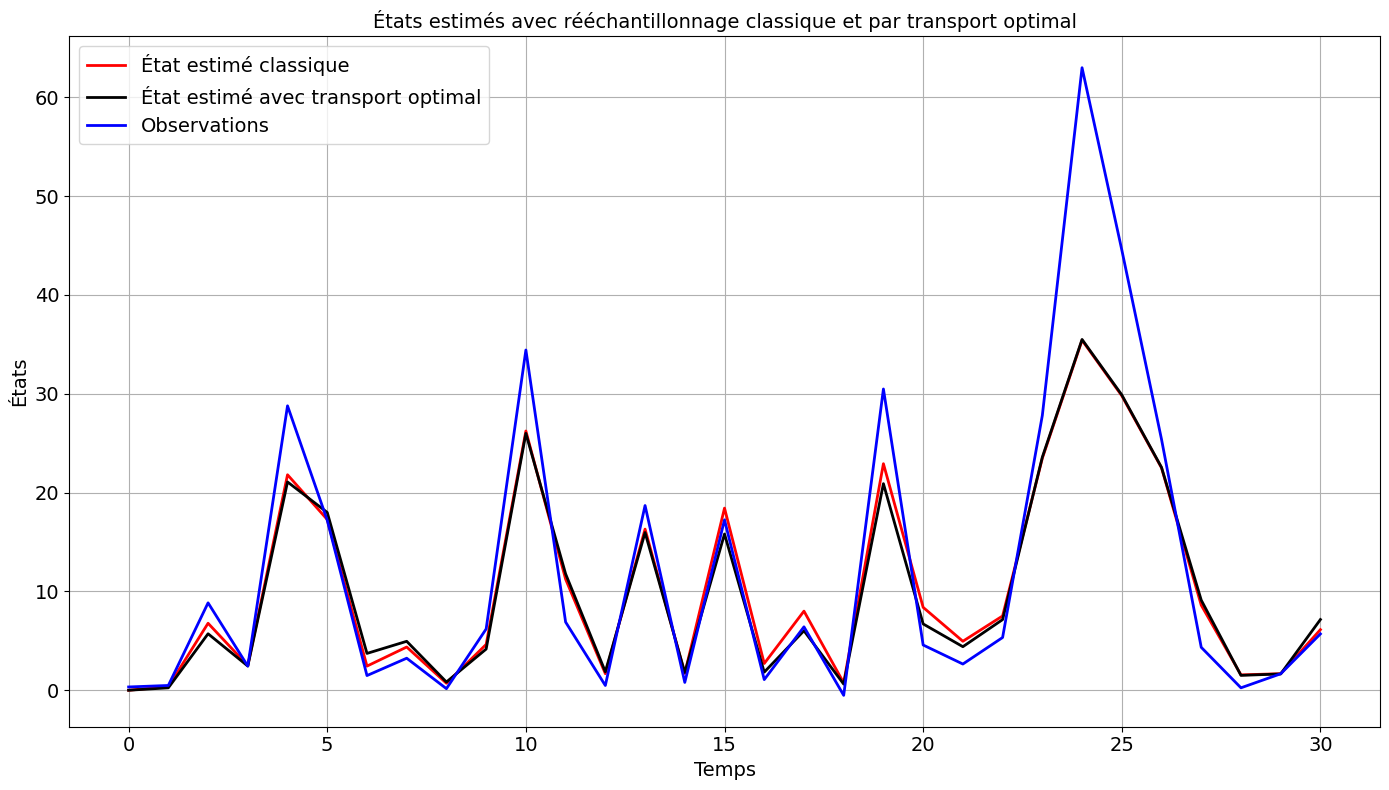

In [6]:
#%% Plotting the results
plt.figure(figsize=(14, 8))

# Plot state estimates for both resampling methods
plt.plot(state_estimates_classic, color='red', linewidth=2, label='État estimé classique')
plt.plot(state_estimates_diff, color='black', linewidth=2, label='État estimé avec transport optimal')
plt.plot(observations[:numberIterations + 1], color='blue', linewidth=2, label='Observations')
plt.title("États estimés avec rééchantillonnage classique et par transport optimal", fontsize=14)
plt.xlabel("Temps", fontsize=14)
plt.ylabel("États", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

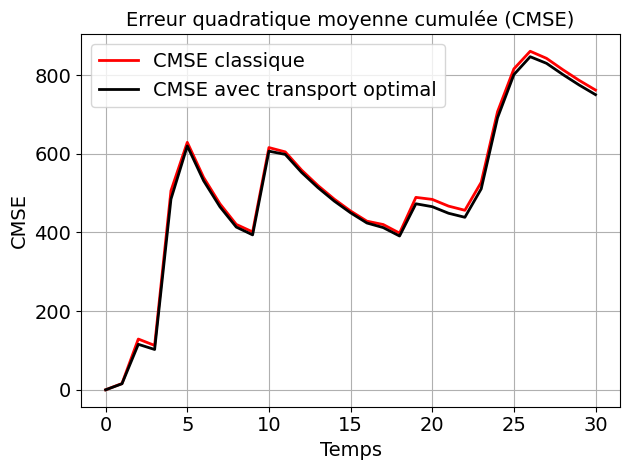

In [7]:
# Plot CMSE for both resampling methods
plt.plot(cmse_classic, color='red', linewidth=2, label='CMSE classique')
plt.plot(cmse_diff, color='black', linewidth=2, label='CMSE avec transport optimal')
plt.title("Erreur quadratique moyenne cumulée (CMSE)", fontsize=14)
plt.xlabel("Temps", fontsize=14)
plt.ylabel("CMSE", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()